In [3]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline

tf.debugging.set_log_device_placement(False)

os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

dry_run = False

In [4]:
import tensorflow as tf 
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
IMAGE_PATH = "../sample_images/monkey.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [6]:
def save_image(image, filename):
    """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
    """
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save(f'{filename}.jpg')
    print(f'Saved as {filename}.jpg')

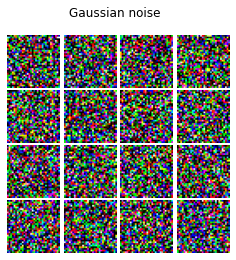

In [7]:
import matplotlib.gridspec as gridspec


def plot_multiple_images(batch, title="", cmap=None, figsize=None):
    """
    Plots batch of images from image tensors.
    """
    batch = tf.cast(tf.clip_by_value(batch, 0, 255), tf.uint8)
    
    X, y = batch
    
    img_size = X.shape[1]
    N = X.shape[0]
    sqrtn = int(np.ceil(np.sqrt(N)))

    fig = plt.figure(figsize=figsize or (sqrtn, sqrtn))
    fig.suptitle(title)

    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)
    for i in range(0, N, 2):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(X[i])
        
        ax = plt.subplot(gs[i+1])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(y[i])


def plot_single_image(image, title="", cmap=None):
    """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
    """
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    plt.title(title)
    
plot_multiple_images(tf.random.normal((2, 16, 32, 32, 3)) * 255, 'Gaussian noise')

In [8]:
import cv2


lr_image = cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_BGR2RGB)
lr_image.shape

(120, 125, 3)

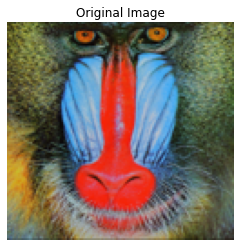

In [9]:
# Plotting Original Resolution image
plot_single_image(lr_image, title="Original Image")

In [10]:
from esrgan import ESRGAN


model = ESRGAN()
model.load()

In [11]:
from json import load as json_load
from os import path


IMAGES_DIR = '../data/img'
CLEAR_IMAGES_DIR = path.join(IMAGES_DIR, 'clear')
DEGRADATED_IMAGES_DIR = path.join(IMAGES_DIR, 'degradated')
ANNOTATION_FILE_PATH = './data/annotation.json'

In [12]:
from abc import ABC, abstractmethod
from glob import glob


# class SRDataset(ABC):
#     lr_images_dir = None
#     hr_images_dir = None
#     batch_size = None
    
#     def __init__(self, img_cmap='rgb'):
#         self.cvt_code = cv2.COLOR_BGR2GRAY if img_cmap == 'gray' else cv2.COLOR_BGR2RGB
    
#     def __iter__(self):
#         lr_img_paths = glob(path.join(self.lr_images_dir, '*'))
#         for i in range(0, len(lr_img_paths), self.batch_size):
#             X, y = [], []
#             for lr_img_fp in lr_img_paths[i:i + self.batch_size]:
#                 lr_image = cv2.cvtColor(cv2.imread(lr_img_fp), self.cvt_code)
#                 _, file_name = path.split(lr_img_fp)

#                 hr_image = cv2.cvtColor(cv2.imread(path.join(self.hr_images_dir, file_name)), self.cvt_code)
                
#                 X.append(cv2.resize(lr_image, (64, 64)))
#                 y.append(cv2.resize(hr_image, (256, 256)))

#             yield tf.constant(X, tf.float32), tf.constant(y, tf.float32)


# class DorianGrayTextDataset(SRDataset):
#     def __init__(self, lr_images_dir, hr_images_dir, batch_size=32, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.lr_images_dir = lr_images_dir
#         self.hr_images_dir = hr_images_dir
#         self.batch_size = batch_size
    
    
# dataset = DorianGrayTextDataset(LR_IMAGES_DIR, HR_IMAGES_DIR, batch_size=50)    
# batch_x, batch_y = next(iter(dataset))

# lr_image, hr_image = tf.squeeze(batch_x[0]).numpy(), tf.squeeze(batch_y[0]).numpy()
# plot_single_image(lr_image, f'LR Image. Shape: {lr_image.shape}')
# plt.figure()
# plot_single_image(hr_image, f'Ground truth HR image. Shape: {hr_image.shape}')

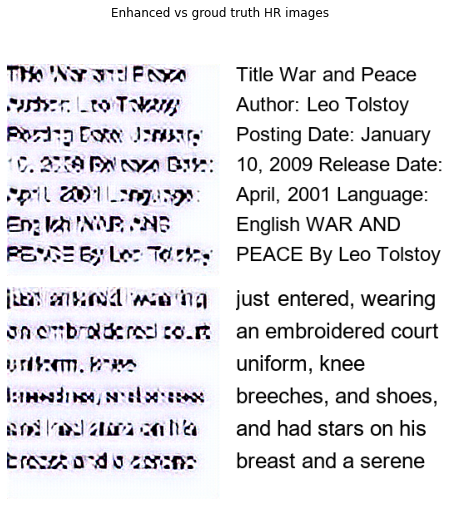

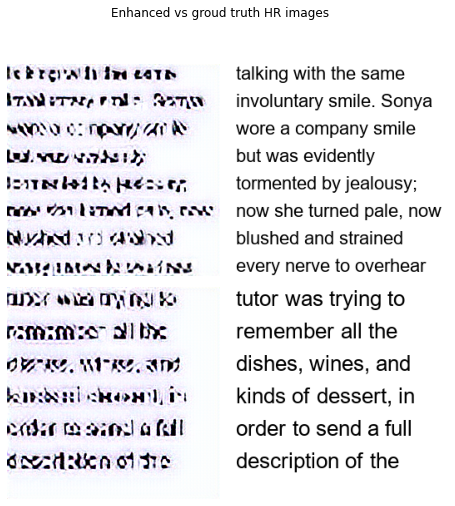

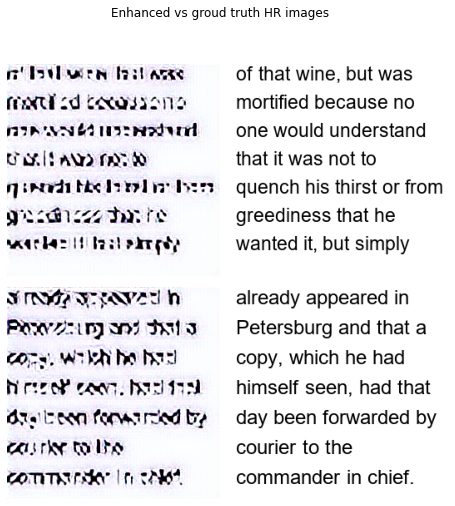

In [13]:
def read_image(fp, target_size):
    """
    Reads image and resizes it with Bicubic interpolation to the target size.
    """
    image_string = tf.io.read_file(fp)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return tf.image.resize(image, target_size, 'bicubic')
    

def prepare_example(hr_image_fp):
    """
    Reads high resolution image and makes one training example from it (low and high resolution images pair).
    """ 
    return read_image(hr_image_fp, LR_IMAGE_SIZE), read_image(hr_image_fp, HR_IMAGE_SIZE)

                       
LR_IMAGE_SIZE = 64, 64
HR_IMAGE_SIZE = 256, 256


def examples_generator():
    for lr_fp in glob(path.join(CLEAR_IMAGES_DIR, '*')):
        yield prepare_example(lr_fp)


def get_dataset():
    return tf.data.Dataset.from_generator(examples_generator, (tf.float32, tf.float32))


ds_iter = iter(get_dataset().batch(4))

for i in range(3):
    X, y = next(ds_iter)
    enhanced_batch = model(X)
    plot_multiple_images([enhanced_batch, y], 'Enhanced vs groud truth HR images', figsize=(8, 8))


In [14]:
mean_batch_psnr = 0.0

if dry_run:
    with tf.device('/GPU:0'):
        batch_size = 50
        dataset = get_dataset()
        for batch_x, batch_y in dataset.batch(batch_size):
            mean_batch_psnr += tf.reduce_mean(tf.image.psnr(model(batch_x), batch_y, 255))

    mean_batch_psnr /= batch_size
    print('PSNR:', float(mean_batch_psnr))

In [15]:
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten, Conv2D, Dense
from tensorflow.keras import Model


class Discriminator(Model):
    def __init__(self, input_shape):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape)
        self.lrelu1 = LeakyReLU()
        self.dropout1 = Dropout(0.3)
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape)
        self.lrelu2 = LeakyReLU()
        self.dropout2 = Dropout(0.3)
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation=None)
    
    def __call__(self, X, training=True):
        outputs = self.conv1(X)
        outputs = self.lrelu1(X)
        outputs = self.dropout1(X)
        
        outputs = self.conv2(X)
        outputs = self.lrelu2(X)
        outputs = self.dropout2(X)

        return self.dense(self.flatten(outputs))
    
    
    def call(self, inputs, training=True):
        return self(inputs, training=training)

    
def test_discriminator():
    batch_size = 8
    inp_shape = batch_size, 256, 256, 3
    d = Discriminator(input_shape=inp_shape)
    assert d(tf.zeros(inp_shape)).shape == (batch_size, 1)
    print('Correct discriminator outputs.')
    

test_discriminator()

Correct discriminator outputs.


In [16]:
class TunedESRGAN(Model):
    def __init__(self, input_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.base_model = hub.KerasLayer('https://tfhub.dev/captain-pool/esrgan-tf2/1', input_shape=input_shape, trainable=True)
        
    def __call__(self, X, training=True):
        return self.base_model(X, training=training)
    
    def call(self, inputs, training=True):
        return self(inputs, training=training)


In [17]:
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
sigmoid = tf.keras.activations.sigmoid

# def discriminator_loss(real_outputs, fake_outputs):
#     return (cross_entropy_loss(tf.zeros_like(fake_outputs), fake_outputs) + 
#             cross_entropy_loss(tf.ones_like(real_outputs), real_outputs))


# def generator_loss(fake_outputs):
#     return cross_entropy_loss(tf.ones_like(fake_outputs), fake_outputs)


def discriminator_loss(real_outputs, fake_outputs):
    """Relativistic discriminator loss"""
    # both real_outputs and fake_outputs are logits(non-transformed discriminator output)
    # real data is more realistic than fake data 
    real_realistics_coeff = sigmoid(real_outputs - tf.reduce_mean(fake_outputs))
    # fake data is less realistic than real data 
    fake_realistics_coeff = sigmoid(fake_outputs - tf.reduce_mean(real_outputs))
    
    return (cross_entropy_loss(tf.zeros_like(fake_outputs), real_realistics_coeff) + 
            cross_entropy_loss(tf.ones_like(real_outputs), fake_realistics_coeff))


def generator_loss(real_outputs, fake_outputs):
    """Relativistic generator loss"""
    # real data is more realistic than fake data 
    real_realistics_coeff = sigmoid(real_outputs - tf.reduce_mean(fake_outputs))
    # fake data is less realistic than real data 
    fake_realistics_coeff = sigmoid(fake_outputs - tf.reduce_mean(real_outputs))
    
    return (cross_entropy_loss(tf.ones_like(fake_outputs), real_realistics_coeff) + 
            cross_entropy_loss(tf.zeros_like(real_outputs), fake_realistics_coeff))

In [18]:
def log(x: tf.Tensor, b):
    """
    Logarithm of x with base=b
    """
    numerator = tf.math.log(x)
    return numerator / tf.math.log(tf.constant(b, dtype=numerator.dtype))


In [19]:
batch_size = 1
lr_image_size, hr_image_size = (64, 64), (256, 256) # HxW
input_lr_shape = (batch_size, *lr_image_size, 3)
input_hr_shape = (batch_size, *hr_image_size, 3)
print_freq = 500

n_epochs = 15
gen_learning_rate = disc_learning_rate = 0.001

cpu = '/CPU:0'
gpu = '/GPU:0'

max_ckpt_to_keep = 5
checkpoint_dir = '../model/checkpoints'
checkpoint_name = 'esrgan-finetune-ckpt'


with tf.device(cpu):
    dataset = get_dataset().batch(batch_size)

with tf.device(gpu):
    
    gen_optimizer = tf.keras.optimizers.Adam(gen_learning_rate)
    disc_optimizer = tf.keras.optimizers.Adam(disc_learning_rate)

    discriminator = Discriminator(input_shape=input_hr_shape)
    generator = TunedESRGAN(input_shape=input_lr_shape)
    checkpoint = tf.train.Checkpoint(
        gen_optimizer=gen_optimizer,
        disc_optimizer=disc_optimizer,
        discriminator=discriminator,
        generator=generator,
    )

    
#     discriminator.build(input_hr_shape)
#     generator.build(input_lr_shape)
    
    ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_ckpt_to_keep, checkpoint_name=checkpoint_name)
    
    # try restoring previous checkpoint or initialize a new one
    restored_ckpt_path = ckpt_manager.restore_or_initialize()
    if restored_ckpt_path:
        print('Restored state from checkpoint {}'.format(repr(restored_ckpt_path)))


In [20]:
from IPython import display
import time
import logging


logger = logging.getLogger()


# @tf.function
# def train_step(lr_batch_images, hr_batch_images):
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         enhanced_images = generator(lr_batch_images, training=True)

#         fake_outputs = discriminator(enhanced_images, training=True)
#         real_outputs = discriminator(hr_batch_images, training=True)

#         gen_loss = 5e-3 * generator_loss(real_outputs, fake_outputs) + 1e-2 * tf.reduce_mean(tf.abs(hr_batch_images - enhanced_batch))
#         disc_loss = discriminator_loss(real_outputs, fake_outputs)
    
#         gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
#         disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

#         gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
#         disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

#     return enhanced_images, gen_loss, disc_loss
    
    
# @tf.function
def train_step(lr_batch_images, hr_batch_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         tape.watch(lr_batch_images)
#         tape.watch(hr_batch_images)
        enhanced_images = generator(lr_batch_images, training=True)

        fake_outputs = discriminator(enhanced_images, training=True)
        real_outputs = discriminator(hr_batch_images, training=True)

        gen_loss = 5e-3 * generator_loss(real_outputs, fake_outputs) + 1e-2 * tf.reduce_mean(tf.abs(hr_batch_images - enhanced_images))
        disc_loss = discriminator_loss(real_outputs, fake_outputs)
    
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return enhanced_images, gen_loss, disc_loss
    

gen_losses, disc_losses = [], []
def train():
    with tf.device(gpu):
        for i_epoch in range(n_epochs):
            display.clear_output(wait=True)
            
            tick = time.time()
            for i_batch, (lr_images, hr_images) in enumerate(dataset):
                enhanced_imgs, gen_loss, disc_loss = train_step(lr_images, hr_images)
                gen_losses.append(gen_loss)
                disc_losses.append(disc_loss)
                #                 print(enhanced_imgs.shape, gen_loss, disc_loss)
                
                psnr = tf.reduce_mean(tf.image.psnr(hr_images, tf.clip_by_value(enhanced_imgs, 0, 255), 255))
#                 print('Epoch {0}. Batch {1}. Generator loss: {2:.4f}. Discriminator loss: {3:.4f}. PSNR: {4:.4f}'.format(
#                     i_epoch, i_batch, float(gen_loss), float(disc_loss), float(psnr)
#                 ))
                
                if (i_batch + 1) % print_freq == 0:
                    print('Epoch {0}. Batch {1}. Generator loss: {2:.4f}. Discriminator loss: {3:.4f}. PSNR: {4:.4f}'.format(
                        i_epoch, i_batch, float(gen_loss), float(disc_loss), float(psnr)
                    ))    
                    plot_multiple_images((enhanced_imgs, hr_images), f'Batch {i_batch} results', figsize=(8, 8))
                    plt.show()
                    ckpt_manager.save()
                    
            tock = time.time()
            logger.info(f'Run epoch #{i_epoch} in {round((tock - tick) / 60, 3)} seconds')


In [ ]:
train()

In [ ]:
dataset = get_dataset().batch(batch_size)

In [ ]:
# (lr_images, hr_images) = next(iter(dataset))

for (lr_images, hr_images) in dataset:
    enhanced_imgs, gen_loss, disc_loss = train_step(lr_images, hr_images)    
    print(enhanced_imgs.shape, gen_loss, disc_loss)